#  <center> Image Classification - Transfer Learning <center>

# Classifying  Steel  Surface  Defects

In [1]:
import os 
import glob 
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://github.com/wwang2/ML4MolEng/blob/master/psets/ps5/neu_surfae_defect_jpg.tar.gz?raw=true
!mv neu_surfae_defect_jpg.tar.gz?raw=true  neu_surfae_defect_jpg.tar.gz
!tar -xf neu_surfae_defect_jpg.tar.gz

--2021-05-06 22:43:22--  https://github.com/wwang2/ML4MolEng/blob/master/psets/ps5/neu_surfae_defect_jpg.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wwang2/ML4MolEng/raw/master/psets/ps5/neu_surfae_defect_jpg.tar.gz [following]
--2021-05-06 22:43:23--  https://github.com/wwang2/ML4MolEng/raw/master/psets/ps5/neu_surfae_defect_jpg.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps5/neu_surfae_defect_jpg.tar.gz [following]
--2021-05-06 22:43:23--  https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps5/neu_surfae_defect_jpg.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

# 1.1 Build Image datasets and dataloaders

In [3]:
# get all image file paths 
files = glob.glob(os.path.join('neu_surfae_defect_images', "*.jpg"))

neu_surfae_defect_images/In_215.jpg


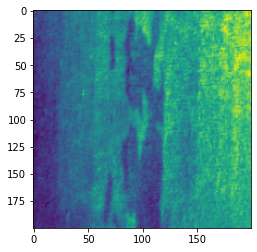

In [4]:
# Visualize images 
idx = 30
img = Image.open(files[idx])
print(files[idx])
#img
plt.imshow(img)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset to train/val/test ( Ratios: 0.8*0.875=0.7 / 0.8*0.125=0.1 / 0.2 )
images_train_val, images_test = train_test_split(files, test_size=0.2)
images_train, images_val = train_test_split(images_train_val, test_size=0.125)


In [6]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T

# dictionary labels 
label_dict = {
'Cr': 0, 
'In': 1, 
'Pa': 2,
'PS': 3, 
'RS': 4,
'Sc': 5
}

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        
        '''
        Image dataset object that load images and transform images
        
        '''
        
        self.paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        # read images given file path 
        img = Image.open(path)
        img = img.convert('RGB')
        
        # transform images 
        if self.transform:
            img = self.transform(img)

        # get label
        for key in label_dict.keys():
          if key in path:
            label = label_dict.get(key)
            label = torch.LongTensor([label])
            break

        return img, label

Build imagedatasets and dataloaders 

In [7]:
image_size = (224, 224)

transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

X_train = ImageDataset(images_train, transform)
X_val = ImageDataset(images_val, transform)
X_test = ImageDataset(images_test, transform)

index = 0

X_index, y_index = X_train.__getitem__(index)
print(X_train[index][1])
print(X_index.shape)
print(y_index)


tensor([0])
torch.Size([3, 224, 224])
tensor([0])


In [8]:
from torch.utils.data import DataLoader

# Build dataloader
batchsize = 4
train_loader = DataLoader(dataset=X_train, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=X_val, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(dataset=X_test, batch_size=batchsize, shuffle=True)


### 1.2 Load Pre-trained VGG16

In [9]:
# load a pretrained VGG 16 model 
from torch import nn 
from torchvision.models import vgg16

# define and load a pretrained VGG16 model
class VGG_fc1(nn.Module):
    def __init__(self, pretrain=True):
        super(VGG_fc1, self).__init__()
        # convolutional layers
        self.features = vgg16(pretrained=pretrain).features # convolutional layers
        # Pooling 
        self.avgpool = vgg16(pretrained=pretrain).avgpool
        # first layer of classifier, output vectors of size 4096
        self.fc1 = vgg16(pretrained=pretrain).classifier[0]
        
    def forward(self, x):
        # apply convolutions 
        x = self.features(x)
        # apply pooling
        x = self.avgpool(x)
        # flatten and convert to vectors
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
model = VGG_fc1(pretrain=True).eval() # turn model into evaluation mode

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [10]:
# convolution architecture
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Visualize filtered images after 1, 5 and 10 convolutions

Chosen channels (at random): [34, 45, 8, 52]


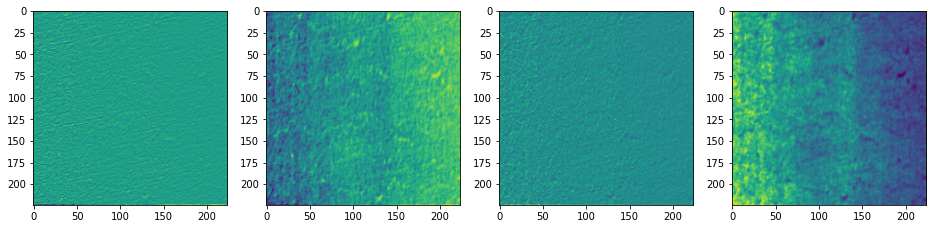

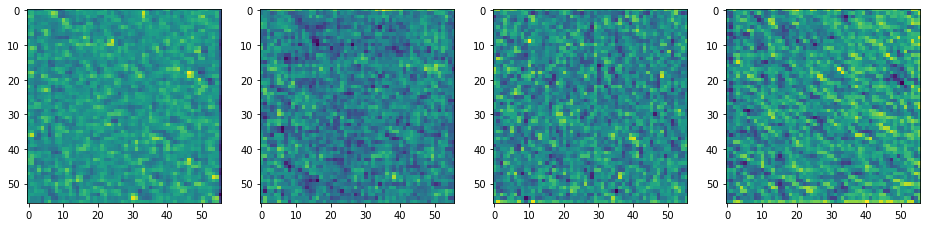

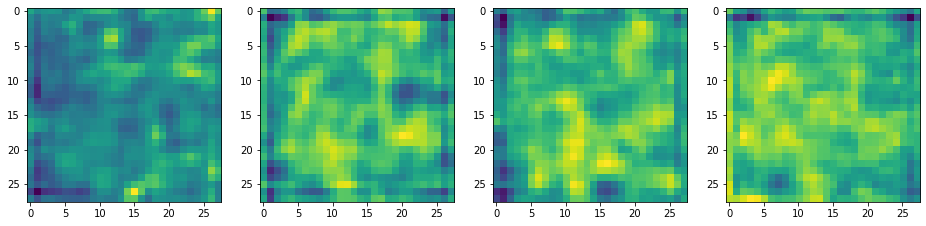

In [11]:
from random import randint


index = 0
image_index, label_index = X_train.__getitem__(index)

img1 = image_index.unsqueeze(0)

# Choose 4 channels at random to visualize
channels = [randint(0, 63) for p in range(0, 4)]

print("Chosen channels (at random): {}".format(channels))

# Sequentially convolve an image and visualize layes 1, 5 and 10
for i in range(23):
  img1 = model.features[i](img1)
  #print(img1.squeeze(0)[0].shape)
  if (i==0) or (i==10) or (i==21):
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    for j in range(columns):
      fig.add_subplot(1, columns, j+1)
      plt.imshow(img1.squeeze(0)[channels[j]].detach().numpy())
    plt.show()


### 1.3 Train an image classifier with transfer learning

Add a trainable MLP as a classifier 

In [12]:

class MLPseq(nn.Module) :
    def __init__(self, input_dim, hidden_dim, output_dim) :
        super().__init__()

        # define a mlp regressor 
        self.mlp = nn.Sequential( nn.Linear(input_dim, hidden_dim), 
                                  nn.ReLU(),  
                                  nn.Linear(hidden_dim, output_dim))
        
        # define a sigmod transform
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        # pass ouput into a MLP 
        logits = self.mlp(x)
        # transform output into probabilites
        # proba = self.sigmoid(logits)
        # return probabilities 
        return logits


In [13]:
from torch import nn
import torch.nn.functional as F

def train(model_VGG, model_MLP, dataloader, loss, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    batch_loss = 0
    model_VGG.eval()
    model_MLP.train() # Set model to training mode 
    
    size = len(dataloader)

    for batch in dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq.requires_grad=True
        
        # Compute prediction error
        features = model_VGG(seq)
        pred = model_MLP(features)
        single_batch_loss = loss(pred.squeeze(), label.squeeze())
        batch_loss += single_batch_loss

        # Backpropagation
        optimizer.zero_grad()
        single_batch_loss.backward()
        optimizer.step()
        
    batch_loss /= size

    return batch_loss


def validate(model_VGG, model_MLP, dataloader, loss, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    size = len(dataloader)
    val_loss = 0
    model_VGG.eval()
    model_MLP.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            
            features = model_VGG(seq)
            pred = model_MLP(features)

            val_loss += loss(pred.squeeze(), label.squeeze())
    
    val_loss /= size
    
    return val_loss

def test_confusion_matrix(model_VGG, model_MLP, dataloader, loss, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    size = len(dataloader)
    test_loss = 0
    model_VGG.eval()
    model_MLP.eval() # Set model to evaluation mode 

    y_true = []
    y_pred = []

    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            
            features = model_VGG(seq)
            pred = model_MLP(features)

            test_loss += loss(pred.squeeze(), label.squeeze())

            y_true.append(label.detach().cpu().numpy())
            y_pred.append(pred.detach().cpu().numpy())
    
    test_loss /= size
    
    return test_loss, y_true, y_pred

finally train classifier 

In [14]:
from torch.optim import Adam

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_VGG = VGG_fc1(pretrain=True).to(device).eval() # turn model into evaluation mode
model_MLP = MLPseq(4096, 2048, 6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_MLP.parameters(), lr=0.001)

In [15]:

print("epoch", "train loss", "validation loss", "test loss")

val_loss_curve = []
train_loss_curve = []
test_loss_curve = []

for epoch in range(5):
    
    # Compute train your model on training data
    epoch_loss = train(model_VGG, model_MLP, train_loader, criterion, optimizer, device)
    
    # Validate your on validation data
    val_loss = validate(model_VGG, model_MLP, val_loader, criterion, device)

    # Test your on testing data
    test_loss, y_true, y_pred = test_confusion_matrix(model_VGG, model_MLP, test_loader, criterion, device) 
    
    # Record train, validation and test loss performance
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    test_loss_curve.append(test_loss)
    
    print(epoch, epoch_loss, val_loss, test_loss)


epoch train loss validation loss test loss
0 tensor(0.4034, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0243, device='cuda:0') tensor(0.0758, device='cuda:0')
1 tensor(0.1314, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0591, device='cuda:0') tensor(0.0551, device='cuda:0')
2 tensor(0.0851, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1427, device='cuda:0') tensor(0.1038, device='cuda:0')
3 tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0002, device='cuda:0') tensor(0.0105, device='cuda:0')
4 tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0013, device='cuda:0') tensor(0.0074, device='cuda:0')


compute and show confusion matrix on test dataset

In [ ]:
#print(y_pred[5])

y_pred_label = [labels for batch in y_pred for labels in batch]
y_true_label = [labels for batch in y_true for labels in batch]

y_pred_label = [label.argmax(axis=0) for label in y_pred_label]


print(len(y_pred_label))
print(len(y_true_label))

print(y_pred_label)
print(y_true_label)

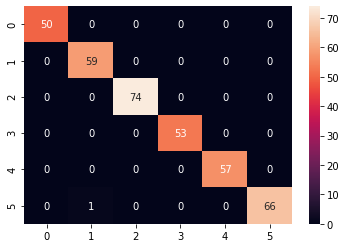

In [17]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true_label, y_pred_label)  

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
plt.show()


### 1.4 Obtain Saliency Maps

In [71]:
## Get two images from the test dataset for the salience maps
img_map = [[] for i in range(6)]
label_map = [[] for i in range(6)]

for j in range(6):

  counter = 0
  for i in range(len(X_test)):
    image_index, label_index = X_test.__getitem__(i)

    if label_index==j:
      img_map[j].append(image_index)
      label_map[j].append(label_index)

      counter += 1
      if counter>=2:
        break


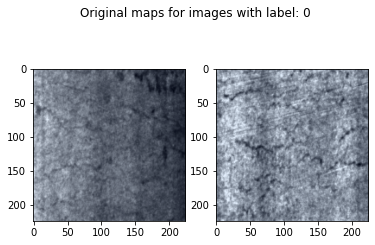

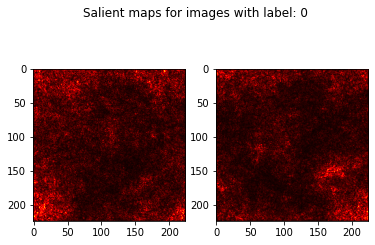

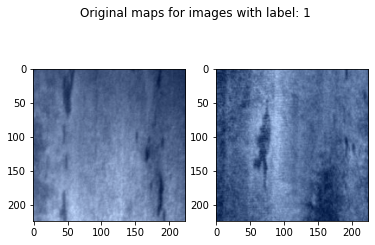

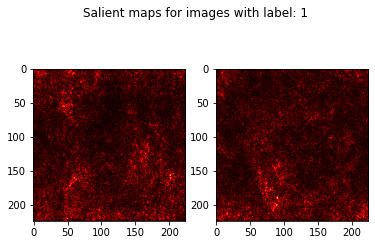

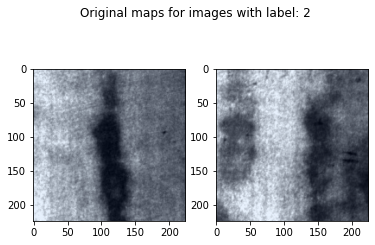

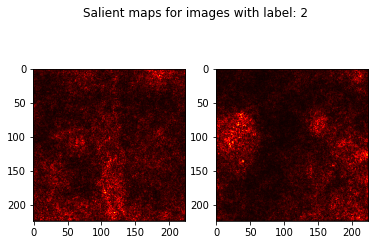

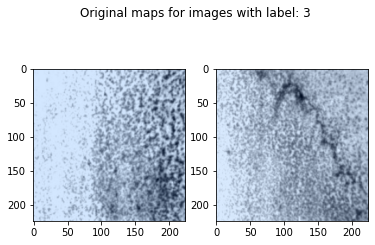

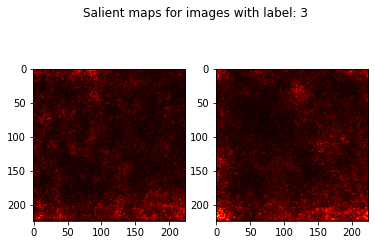

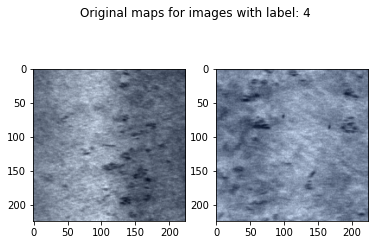

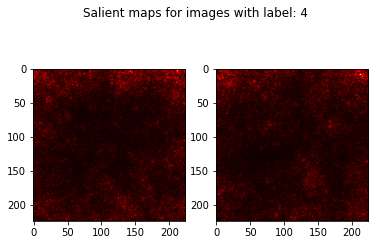

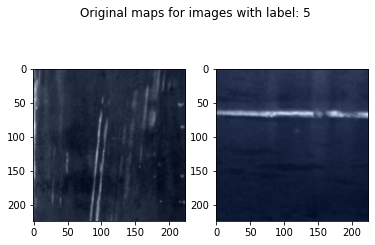

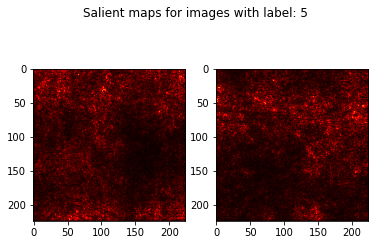

In [72]:
import cv2

# Obtain and create salience maps for the selected images
model_VGG.eval()
model_MLP.eval()

for j in range(6):

  fig = plt.figure()
  plt.suptitle("Original maps for images with label: {}".format(j))

  for i in range(2):

    norm_map = cv2.normalize(img_map[j][i].detach().cpu().numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_map = norm_map.astype(np.uint8)

    fig.add_subplot(1, 2, i+1)
    plt.imshow(np.transpose(norm_map,(1,2,0)))

  plt.show()

  fig = plt.figure()
  plt.suptitle("Salient maps for images with label: {}".format(j))

  for i in range(2):
    x_map = img_map[j][i]
    x_map = x_map.detach().to(device)
    x_map.requires_grad=True

    features = model_VGG(x_map.unsqueeze(0))
    y = model_MLP(features).max()
    y.backward()

    x_map_grad = x_map.grad.data
    x_map_grad = torch.abs(x_map_grad)
    x_map_grad = torch.mean(x_map_grad, dim=0)

    fig.add_subplot(1, 2, i+1)
    plt.imshow(x_map_grad.detach().cpu().numpy(), 'hot')

  plt.show()
